# Prepare Data

In [181]:
import pandas as pd

pd.options.mode.copy_on_write = True

YEARS = [2023]

df = pd.read_csv(f'data_Energy_Germany/Realised_Demand_Germany_{YEARS[0]}.csv', sep=';')

df.drop(['Residual Load [MWh]', 'Pumped Storage [MWh]', 'Date to'], axis=1, inplace=True)
df.rename(columns={'Date from': 'date_from', 'Total (Grid Load) [MWh]': 'grid_load'}, inplace=True)

# convert to datetime columns

df['date_from'] = pd.to_datetime(df['date_from'], format='%d.%m.%y %H:%M').dt.tz_localize('Europe/Berlin', ambiguous='infer')

# # handle date_to edge case where data contains 03:00 instead of 02:00 as duplicate DST value
# strange_idx = (df['date_to'] == '29.10.23 03:00').idxmax()
# df.loc[strange_idx, 'date_to'] = df['date_to'][strange_idx].replace('03:00', '02:00')
# df['date_to'] =  pd.to_datetime(df['date_to'], format='%d.%m.%y %H:%M')  # .dt.tz_localize('Europe/Berlin', ambiguous='infer')

# convert to float column
df.grid_load = df.grid_load.str.replace('.', '').str.replace(',', '.')  # clean float representation
df = df.astype({'grid_load': float})

df.head()

,date_from,grid_load
0,2023-01-01 00:00:00+01:00,9720.75
1,2023-01-01 00:15:00+01:00,9641.25
2,2023-01-01 00:30:00+01:00,9609.50
3,2023-01-01 00:45:00+01:00,9565.00
4,2023-01-01 01:00:00+01:00,9473.50


In [190]:
# todo: handle date_to edge case more generally

# from zoneinfo import ZoneInfo
# from more_itertools import nth

# berlin_zone = ZoneInfo("Europe/Berlin")

# def is_dst(date):
#     return berlin_zone.dst(date).seconds > 0

# # strange_dates = df['date_to'][strange_idx-10: strange_idx+10]
# strange_dsts = list(map(is_dst, df['date_to']))
# strange_idx2 = strange_dsts.index(False)
# nth(df['date_to'], strange_idx2)

In [182]:
from holidays.utils import country_holidays


# === categorize days ===

german_holidays = country_holidays('DE', years=YEARS)
holiday_dates = set(german_holidays.keys())

def get_day_type(timestamp):
    if timestamp.date() in holiday_dates or timestamp.day_name() == 'Sunday':
        # holiday/sunday
        return 2
    elif timestamp.day_name() == 'Saturday':
        # saturday
        return 1
    else:
        # workday
        return 0

df = df.assign(day_type=df.date_from.map(get_day_type))
df.head()

,date_from,grid_load,day_type
0,2023-01-01 00:00:00+01:00,9720.75,2
1,2023-01-01 00:15:00+01:00,9641.25,2
2,2023-01-01 00:30:00+01:00,9609.50,2
3,2023-01-01 00:45:00+01:00,9565.00,2
4,2023-01-01 01:00:00+01:00,9473.50,2


In [ ]:
grid_load_prev = [None] + list(df.grid_load)
grid_load_last_week = df.where()

# LinReg

In [113]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split


# prepare data

n_steps_ahead = 1  # 4 * 24  # 1 day ahead

arr = df['grid_load']
X = np.array(arr[:-n_steps_ahead]).reshape(-1, 1)  # (n_samples, n_features)
y = np.array(arr[n_steps_ahead:]).reshape(-1, 1)  # (n_samples, n_targets)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17519, 1), (17520, 1), (17519, 1), (17520, 1))

In [114]:
# === perform regression ===

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [[0.99738755]]
Mean squared error: 26823.63
Coefficient of determination: 0.99


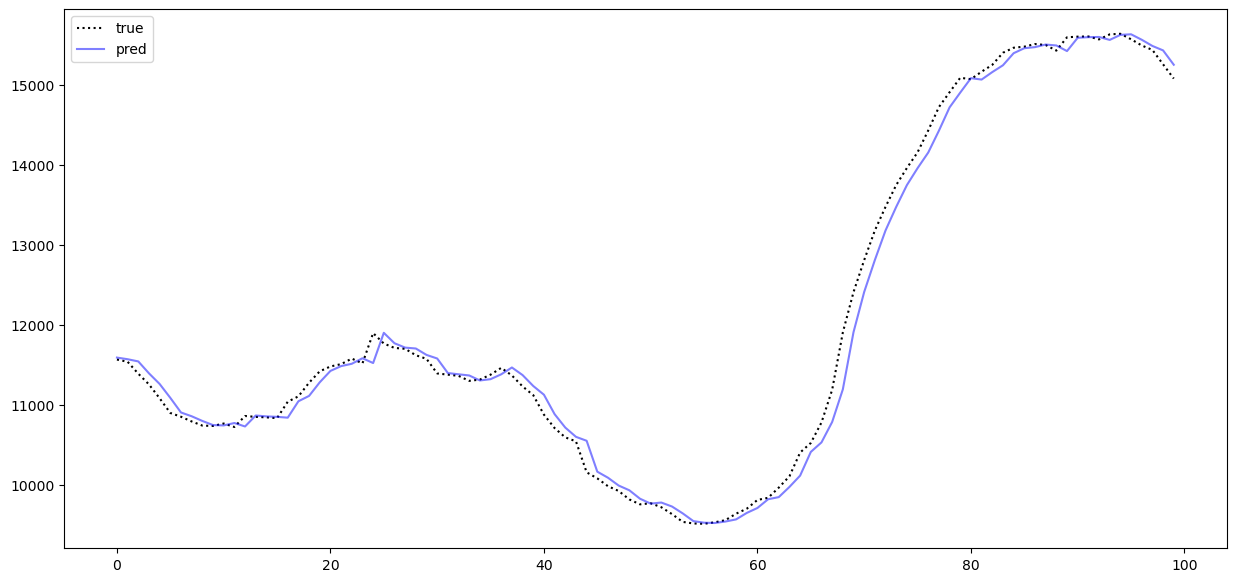

In [115]:
# === plot ===

x_plot = np.arange(X_test.size)

# Plot outputs

fig, ax = plt.subplots(figsize=(15,7))

n_points = 100

plt.plot(x_plot[:n_points], y_test[:n_points], color="black", label='true', linestyle='dotted')
# plt.plot(x_plot[:n_points], X_test[:n_points], color="red", label='inputs', linestyle='dashed')
plt.plot(x_plot[:n_points], y_pred[:n_points], color="blue", label='pred', alpha=0.5)

# plt.xticks(())
# plt.yticks(())

plt.legend()
plt.show()